In [496]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
string.punctuation
from nltk.corpus import stopwords
stopwords.words('english')
from nltk import PorterStemmer

from feature_engine.imputation import MeanMedianImputer
from feature_engine.encoding import OneHotEncoder, MeanEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [497]:
df = pd.read_csv('../amazon_alexa.tsv', sep = '\t')
df.head(20)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [498]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [499]:
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [500]:
df['variation'].nunique()

16

In [501]:
df['length'] = df['verified_reviews'].apply(len)
df['length'].describe()

count    3150.000000
mean      132.049524
std       182.099952
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

<Figure size 2000x2000 with 0 Axes>

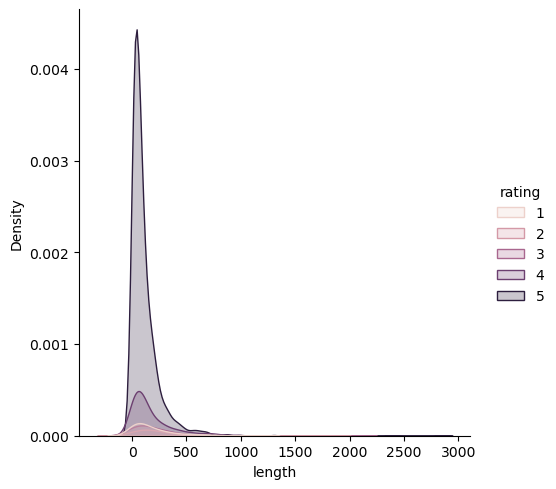

In [502]:
plt.figure(figsize = (20, 20))
sns.displot(data = df, x = 'length', kind = 'kde', hue = 'rating', fill = True)
plt.show()

### Conclusion:
    - In this graph, we see that the length of all ratings is almost in the same range, but with different density

In [503]:
df.isnull().mean()

rating              0.0
date                0.0
variation           0.0
verified_reviews    0.0
feedback            0.0
length              0.0
dtype: float64

In [504]:
df['date']

0       31-Jul-18
1       31-Jul-18
2       31-Jul-18
3       31-Jul-18
4       31-Jul-18
          ...    
3145    30-Jul-18
3146    30-Jul-18
3147    30-Jul-18
3148    30-Jul-18
3149    29-Jul-18
Name: date, Length: 3150, dtype: object

In [505]:
df['date_d'] = pd.to_datetime(df.date)
df['date_year'] = df['date_d'].dt.year
df['date_month'] = df['date_d'].dt.month
df['date_day'] = df['date_d'].dt.day
df[['date_d', 'date_year', 'date_month', 'date_day']].head()

,date_d,date_year,date_month,date_day
0,2018-07-31,2018,7,31
1,2018-07-31,2018,7,31
2,2018-07-31,2018,7,31
3,2018-07-31,2018,7,31
4,2018-07-31,2018,7,31


In [506]:
df['date_year'].nunique()

1

In [507]:
df['date_month'].nunique()

3

In [508]:
df.drop(labels = ['date', 'date_d'], axis = 1, inplace = True)

In [509]:
df['target'] = df['rating'].replace({5: 1, 4: 0, 3: 0, 2: 0, 1: 0})
df

,rating,variation,verified_reviews,feedback,length,date_year,date_month,date_day,target
0,5,Charcoal Fabric,Love my Echo!,1,13,2018,7,31,1
1,5,Charcoal Fabric,Loved it!,1,9,2018,7,31,1
2,4,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195,2018,7,31,0
3,5,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172,2018,7,31,1
4,5,Charcoal Fabric,Music,1,5,2018,7,31,1
...,...,...,...,...,...,...,...,...,...
3145,5,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,50,2018,7,30,1
3146,5,Black Dot,"Listening to music, searching locations, check...",1,135,2018,7,30,1
3147,5,Black Dot,"I do love these things, i have them running my...",1,441,2018,7,30,1
3148,5,White Dot,Only complaint I have is that the sound qualit...,1,380,2018,7,30,1


<AxesSubplot: xlabel='feedback', ylabel='count'>

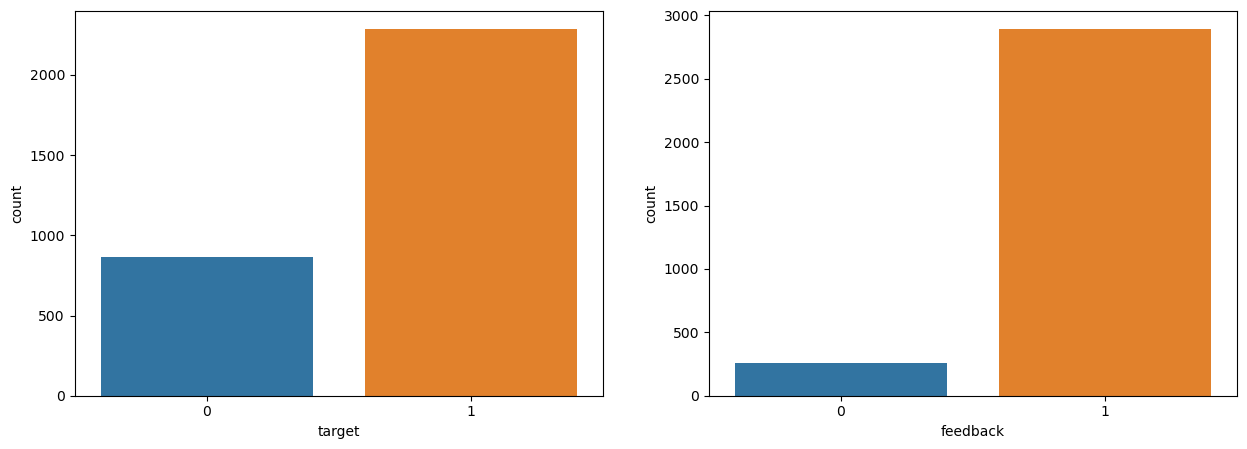

In [510]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x = df['target'])
plt.subplot(1, 2, 2)
sns.countplot(x = df['feedback'])

### Conclusion:
    - there are more positive reviews in our dataset than negative ones

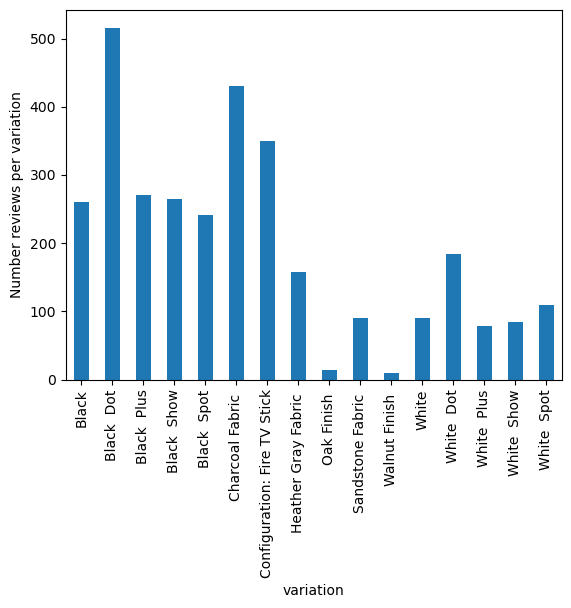

In [511]:
(df.groupby(['variation'])['verified_reviews'].count()).plot.bar()
plt.ylabel('Number reviews per variation')
plt.show()

### Conclusion:
    - in this graph we see which products have the most reviews

<AxesSubplot: xlabel='rating', ylabel='variation'>

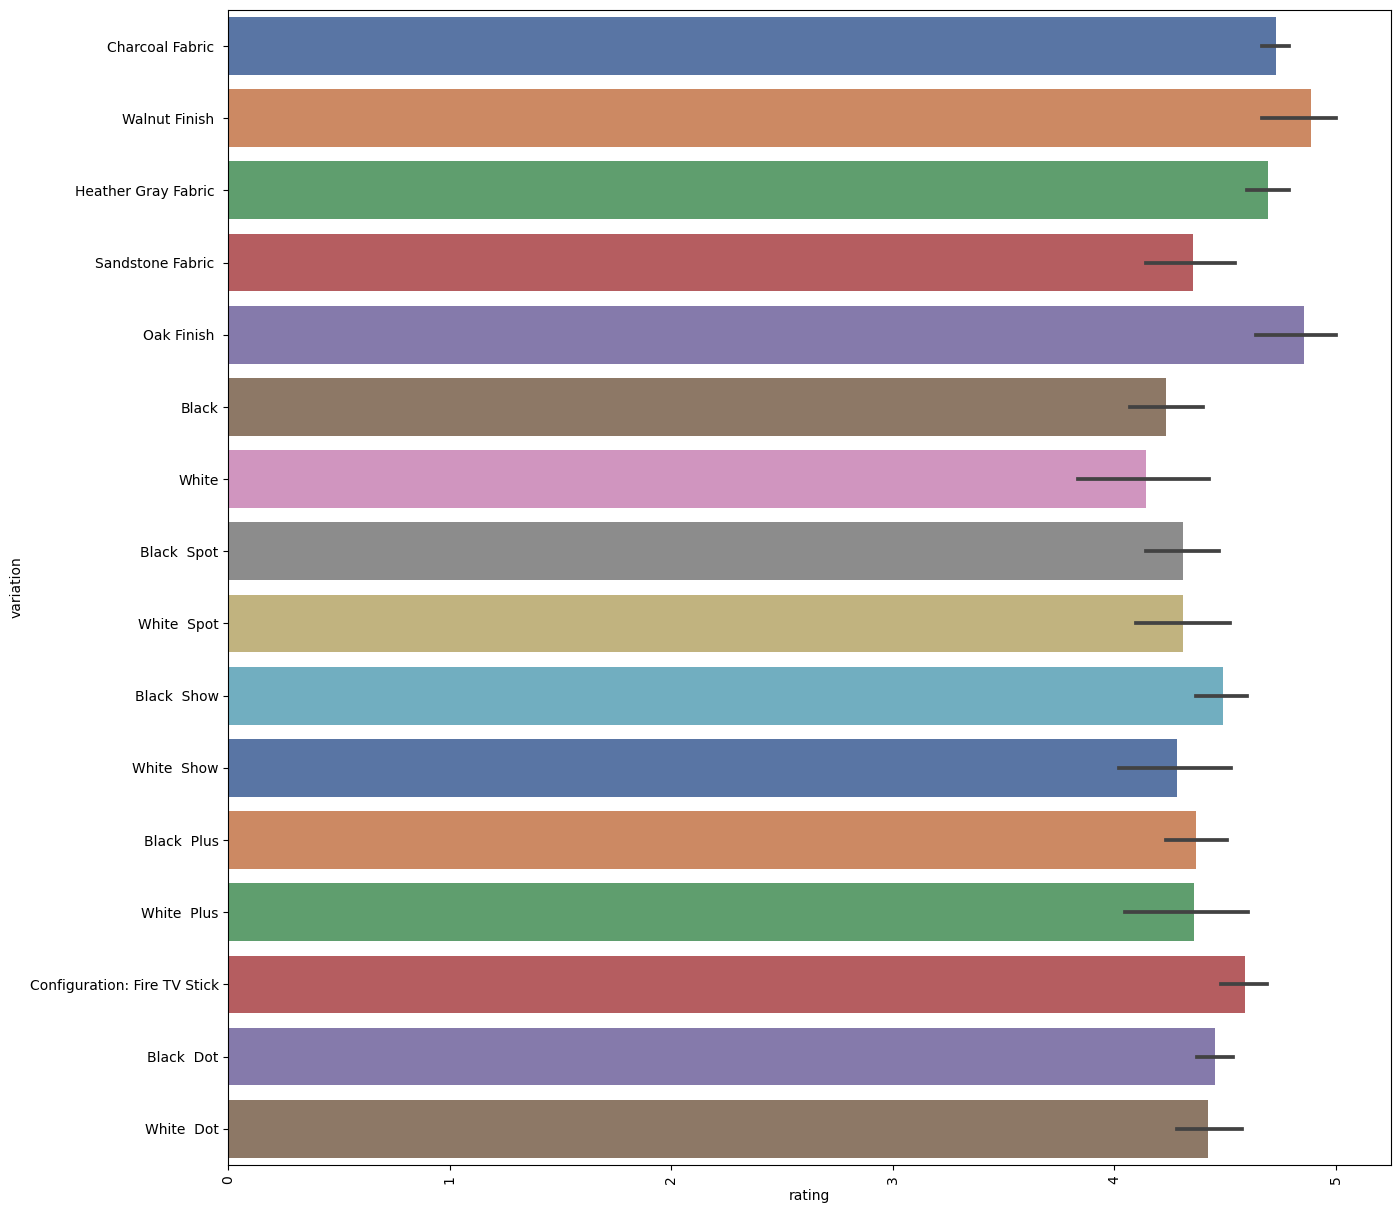

In [512]:
plt.figure(figsize = (15, 15))
plt.xticks(rotation = 90)
sns.barplot(x = 'rating', y = 'variation', data = df, palette = 'deep')

### Conclusion:
    - From this graph, you can see that the rating for all products is between 4 and 5

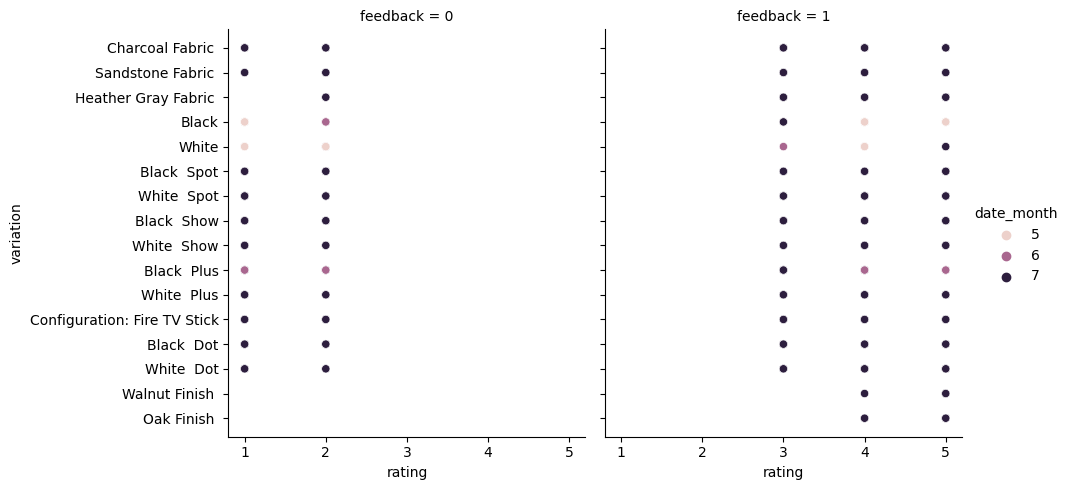

In [513]:
sns.relplot(data = df, x = 'rating', y = 'variation', kind = 'scatter', col = 'feedback', hue = 'date_month')

### Conclusion:
    - here we see that most of the reviews were left for the month of July. For the month of May there were reviews of only two products

<Figure size 1000x800 with 0 Axes>

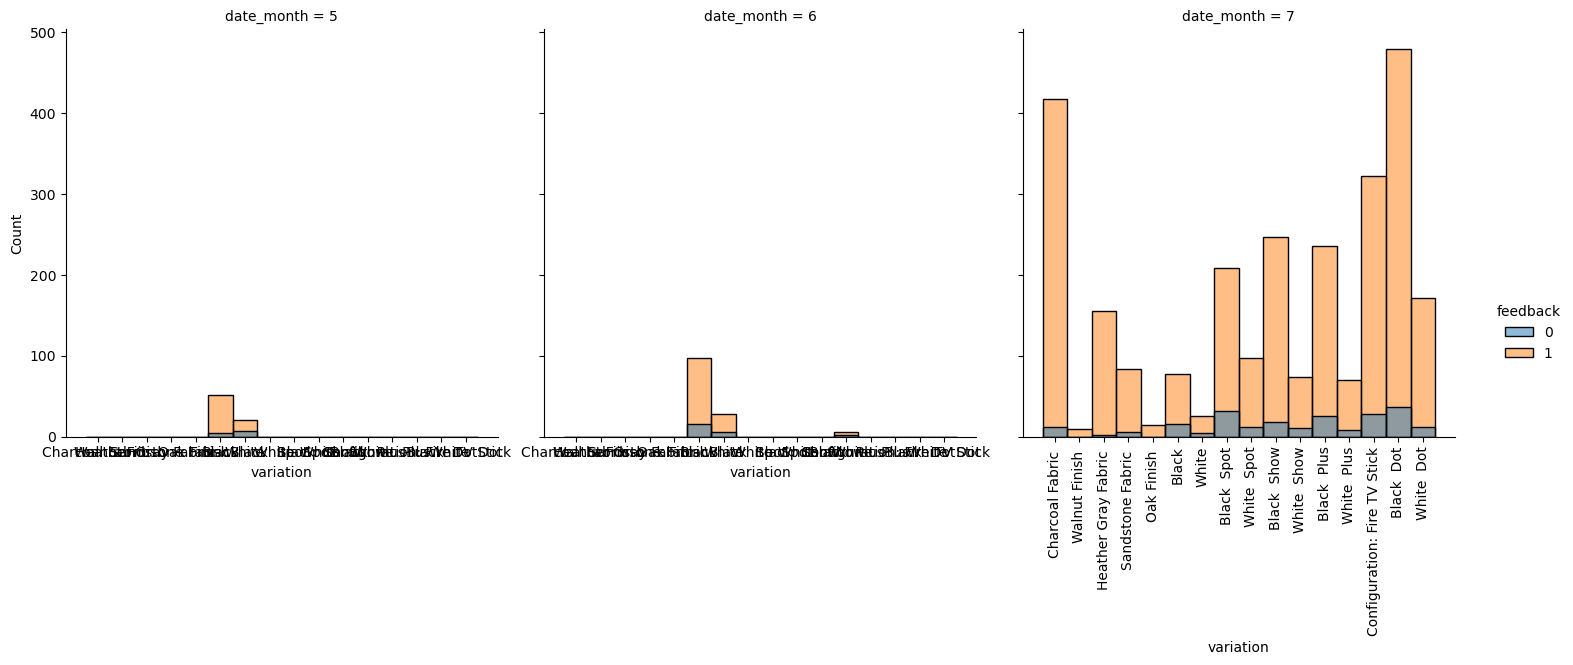

In [514]:
plt.figure(figsize = (10, 8))
sns.displot(data = df, x = 'variation', kind = 'hist', col = 'date_month', hue = 'feedback')
plt.xticks(rotation = 90)
plt.show()

### Conclusion:
    - in this graph we see the number of positive and negative reviews for each product by month

In [515]:
df_1 = df[df['rating'] == 1]
df_2 = df[df['rating'] == 2]
df_3 = df[df['rating'] == 3]
df_4 = df[df['rating'] == 4]
df_5 = df[df['rating'] == 5]

In [516]:
df

,rating,variation,verified_reviews,feedback,length,date_year,date_month,date_day,target
0,5,Charcoal Fabric,Love my Echo!,1,13,2018,7,31,1
1,5,Charcoal Fabric,Loved it!,1,9,2018,7,31,1
2,4,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195,2018,7,31,0
3,5,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172,2018,7,31,1
4,5,Charcoal Fabric,Music,1,5,2018,7,31,1
...,...,...,...,...,...,...,...,...,...
3145,5,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,50,2018,7,30,1
3146,5,Black Dot,"Listening to music, searching locations, check...",1,135,2018,7,30,1
3147,5,Black Dot,"I do love these things, i have them running my...",1,441,2018,7,30,1
3148,5,White Dot,Only complaint I have is that the sound qualit...,1,380,2018,7,30,1


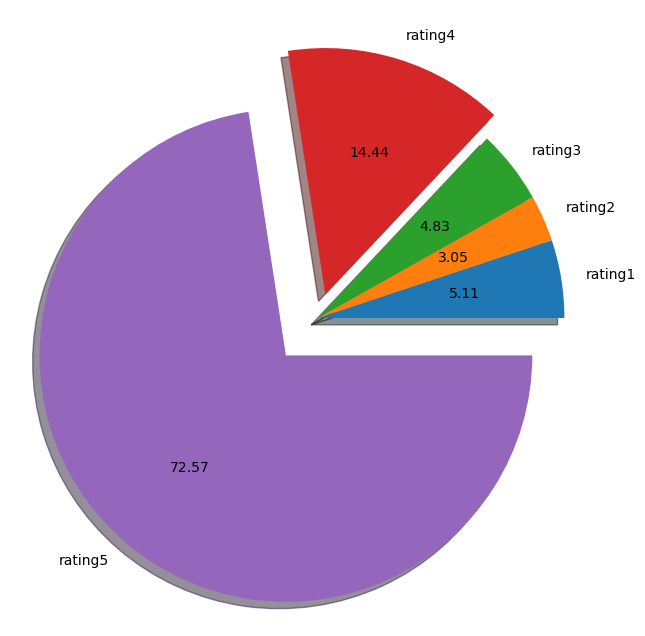

In [517]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()
cols = [len(df_1), len(df_2), len(df_3), len(df_4), len(df_5)]
labels = ['rating1', 'rating2', 'rating3', 'rating4', 'rating5' ]
exp = (0, 0, 0, 0.1, 0.2)
ax.pie(cols, labels = labels, autopct = '%.2f', explode = exp, shadow = True)
ax.grid()
plt.show()

### Conclusion:
    - in this graph we see the shares of ratings as a percentage

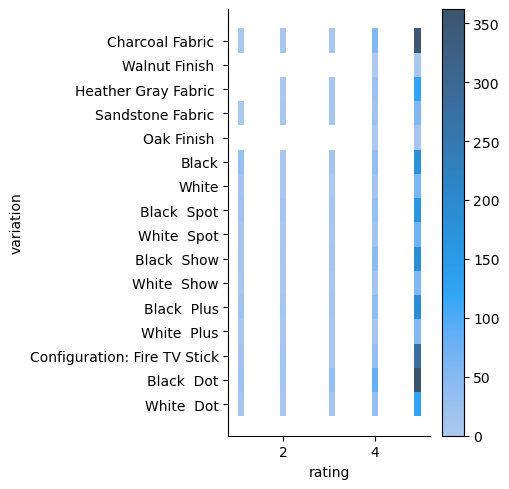

In [518]:
sns.displot(data = df, x = 'rating', y = 'variation', cbar = True)

### Conclusion:
    - from this graph we can see which products are assigned certain ratings and in what quantity

## Preprocessing

In [519]:
def text_cleaning(text):
    text_remove_punc = [char for char in text if char not in string.punctuation]
    text_join = ''.join(text_remove_punc)
    finished_text = [word.lower() for word in text_join.split() if word not in stopwords.words('english')]
    
    return finished_text

In [520]:
df_text = df['verified_reviews'].apply(text_cleaning)
df_text

0                                            [love, echo]
1                                                 [loved]
2       [sometimes, playing, game, answer, question, c...
3       [i, lot, fun, thing, my, 4, yr, old, learns, d...
4                                                 [music]
                              ...                        
3145                    [perfect, kids, adults, everyone]
3146    [listening, music, searching, locations, check...
3147    [i, love, things, running, entire, home, tv, l...
3148    [only, complaint, i, sound, quality, isnt, gre...
3149                                               [good]
Name: verified_reviews, Length: 3150, dtype: object

In [521]:
vectorizer = CountVectorizer(analyzer = text_cleaning)
review_countvectorizer = vectorizer.fit_transform(df['verified_reviews'])

In [522]:
print(vectorizer.get_feature_names())

['072318', '1', '10', '100', '1000', '100x', '1010', '1030pm', '11', '1100sf', '1220', '129', '12am', '15', '150', '19', '1964', '1990s', '1990’s', '1gb', '1rst', '1st', '2', '20', '200', '2000', '2017', '2030', '229', '23', '2448', '247', '24ghz', '25', '29', '299', '2999', '2nd', '2or', '2original', '2package', '3', '30', '300', '30so', '334', '34', '342nd', '3434', '34a34', '34alexa', '34alexa34', '34card34', '34certified', '34computer34', '34cycle', '34cycle34', '34dot34', '34drop', '34first', '34fixes34', '34fun34', '34group34', '34hear34', '34hmm', '34hmmm', '34hub', '34i', '34im', '34it34', '34late', '34learn', '34light34', '34lights34', '34listen34', '34minor', '34never', '34outlet34', '34personal34', '34philips', '34play', '34second', '34she34', '34show', '34skills34', '34smart', '34smart34', '34sorry', '34spying34', '34tell', '34the', '34thick34', '34things', '34this', '34thongs', '34trouble', '34try', '34turn', '34visual34', '34wake34me', '34warehouse34', '34whats', '35', '3

/opt/anaconda3/envs/KV-AI-JLM-7/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [523]:
fetaure_names = vectorizer.get_feature_names()
fetaure_names

['072318',
 '1',
 '10',
 '100',
 '1000',
 '100x',
 '1010',
 '1030pm',
 '11',
 '1100sf',
 '1220',
 '129',
 '12am',
 '15',
 '150',
 '19',
 '1964',
 '1990s',
 '1990’s',
 '1gb',
 '1rst',
 '1st',
 '2',
 '20',
 '200',
 '2000',
 '2017',
 '2030',
 '229',
 '23',
 '2448',
 '247',
 '24ghz',
 '25',
 '29',
 '299',
 '2999',
 '2nd',
 '2or',
 '2original',
 '2package',
 '3',
 '30',
 '300',
 '30so',
 '334',
 '34',
 '342nd',
 '3434',
 '34a34',
 '34alexa',
 '34alexa34',
 '34card34',
 '34certified',
 '34computer34',
 '34cycle',
 '34cycle34',
 '34dot34',
 '34drop',
 '34first',
 '34fixes34',
 '34fun34',
 '34group34',
 '34hear34',
 '34hmm',
 '34hmmm',
 '34hub',
 '34i',
 '34im',
 '34it34',
 '34late',
 '34learn',
 '34light34',
 '34lights34',
 '34listen34',
 '34minor',
 '34never',
 '34outlet34',
 '34personal34',
 '34philips',
 '34play',
 '34second',
 '34she34',
 '34show',
 '34skills34',
 '34smart',
 '34smart34',
 '34sorry',
 '34spying34',
 '34tell',
 '34the',
 '34thick34',
 '34things',
 '34this',
 '34thongs',
 '

In [524]:
df.drop(labels = ['verified_reviews'], axis = 1, inplace = True)
reviews = pd.DataFrame(review_countvectorizer.toarray(), columns = fetaure_names)

In [525]:
reviews_without_digit = reviews.copy()

In [526]:
for feat in fetaure_names:
    if feat.isdigit():
        reviews_without_digit.drop(feat, axis = 1, inplace = True)
reviews_without_digit

,100x,1030pm,1100sf,12am,1990s,1990’s,1gb,1rst,1st,24ghz,...,😉,😊,😍,😍💋💋💋💋❤,😎,😏,😑,😬,😳,🤓
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [527]:
encoder = OneHotEncoder(drop_last = True)
enc_variation = encoder.fit_transform(pd.DataFrame(df['variation']))
enc_variation

,variation_Charcoal Fabric,variation_Walnut Finish,variation_Heather Gray Fabric,variation_Sandstone Fabric,variation_Oak Finish,variation_Black,variation_White,variation_Black Spot,variation_White Spot,variation_Black Show,variation_White Show,variation_Black Plus,variation_White Plus,variation_Configuration: Fire TV Stick,variation_Black Dot
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [528]:
df.drop(['variation', 'rating'], axis = 1, inplace = True)
df

,feedback,length,date_year,date_month,date_day,target
0,1,13,2018,7,31,1
1,1,9,2018,7,31,1
2,1,195,2018,7,31,0
3,1,172,2018,7,31,1
4,1,5,2018,7,31,1
...,...,...,...,...,...,...
3145,1,50,2018,7,30,1
3146,1,135,2018,7,30,1
3147,1,441,2018,7,30,1
3148,1,380,2018,7,30,1


In [529]:
df_exp = df.copy()
df_wdig = df.copy()

## Check

In [530]:
label = df['feedback'].values

In [531]:
NB_clf = MultinomialNB()
NB_clf.fit(reviews, label)

MultinomialNB()

In [532]:
test = ['good product']
test_v = vectorizer.transform(test)
test_predict = NB_clf.predict(test_v)
test_predict

/opt/anaconda3/envs/KV-AI-JLM-7/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


array([1])

## Pipeline with feedback without deleting digital variables in text variable

In [533]:
reviews.drop(['feedback', 'length'], axis = 1, inplace = True)

In [534]:
df_main = pd.concat([
    df,
    reviews,
    enc_variation
], axis = 1)

In [535]:
X = df_main.drop(['target', 'feedback'], axis = 1)
y = df_main['feedback']

In [536]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [537]:
X_train.shape, X_test.shape

((2205, 4595), (945, 4595))

In [538]:
algorithms = [
    ('Stochastic Gradient Decent', SGDClassifier()),
    ('Random Forest', RandomForestClassifier(n_estimators = 300)),
    ('Ada Boost', AdaBoostClassifier()),
    ('XGBoost', XGBClassifier()),
    ('Decision Tree', DecisionTreeClassifier(max_depth = 5)),
    ('Gradient boost', GradientBoostingClassifier()),
    ('SVC', SVC(kernel = 'poly')),
]

In [539]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    algorithms
])

for name, algorithm in algorithms:
    pipe.steps[-1] = (name, algorithm)
    
    pipe.fit(X_train, y_train)
    y_pred_test = pipe.predict(X_test)
    y_pred_train = pipe.predict(X_train)
    
    train_set = round(pipe.score(X_train, y_train) * 100, 2)
    test_set = round(pipe.score(X_test, y_test) * 100, 2)
    
    print(f"Train dataset with {name}: {train_set}%")
    print(f"Test dataset with {name}: {test_set}%")
    
    print(classification_report(y_train, y_pred_train))
    print(classification_report(y_test, y_pred_test))
    
    confusion_matrix(y_train, y_pred_train)
    confusion_matrix(y_test, y_pred_test)
    
    scores = cross_val_score(pipe, X_train, y_train, cv = 10, scoring = 'accuracy')

    print('Scores: ', scores, "\n")
    print('Mean: ', scores.mean(), '\n')
    print('Standard deviation: ', scores.std())

Train dataset with Stochastic Gradient Decent: 98.0%
Test dataset with Stochastic Gradient Decent: 93.02%
              precision    recall  f1-score   support

           0       1.00      0.74      0.85       172
           1       0.98      1.00      0.99      2033

    accuracy                           0.98      2205
   macro avg       0.99      0.87      0.92      2205
weighted avg       0.98      0.98      0.98      2205

              precision    recall  f1-score   support

           0       0.95      0.24      0.38        85
           1       0.93      1.00      0.96       860

    accuracy                           0.93       945
   macro avg       0.94      0.62      0.67       945
weighted avg       0.93      0.93      0.91       945

Scores:  [0.93665158 0.9321267  0.92760181 0.92307692 0.94117647 0.93181818
 0.94545455 0.92727273 0.93181818 0.92272727] 

Mean:  0.9319724393253803 

Standard deviation:  0.00703022165158242
Train dataset with Random Forest: 99.77%
Test d

### Graphs to display performance

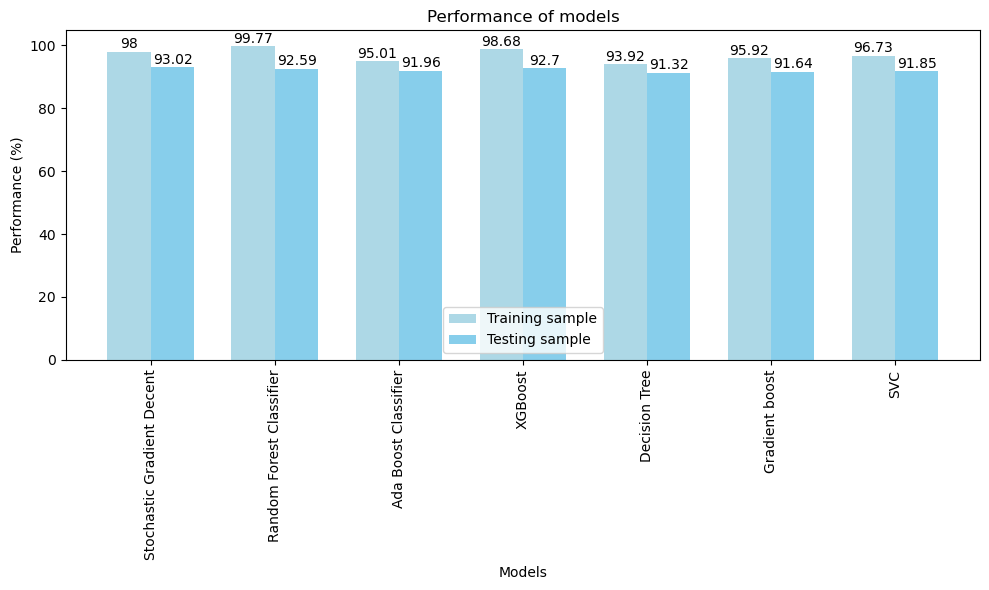

In [554]:
models = ['Stochastic Gradient Decent', 'Random Forest Classifier', 'Ada Boost Classifier', 'XGBoost', 
          'Decision Tree', 'Gradient boost', 'SVC']

X_train_mean_performance = [98, 99.77, 95.01, 98.68, 93.92, 95.92, 96.73]
X_test_mean_performance = [93.02, 92.59, 91.96, 92.7, 91.32, 91.64, 91.85]

bar_width = 0.35

plt.figure(figsize=(10, 6))

index = range(len(models))

plt.bar(index, X_train_mean_performance, bar_width, color = 'lightblue', label = 'Training sample')

plt.bar([i + bar_width for i in index], X_test_mean_performance, bar_width, color = 'skyblue', label = 'Testing sample')

plt.title('Performance of models')
plt.xlabel('Models')
plt.ylabel('Performance (%)')

plt.xticks([i + bar_width / 2 for i in index], models, rotation = 90)

plt.legend()

for i, value in enumerate(X_train_mean_performance):
    plt.text(i, value + 1, str(value), ha = 'center')

for i, value in enumerate(X_test_mean_performance):
    plt.text(i + bar_width, value + 1, str(value), ha = 'center')

plt.tight_layout()
plt.show()

### Conclusion:
    - we see that the Decision Tree Classifier model showed the best performance. The other models performed a little worse.

## Pipeline with feedback with deleted digital variables in text variable

In [541]:
reviews_without_digit.drop(['feedback', 'length'], axis = 1, inplace = True)
df_wdig = pd.concat([
    df_wdig,
    reviews_without_digit,
    enc_variation
], axis = 1)

In [542]:
X = df_wdig.drop(labels = ['feedback', 'target'], axis = 1)
y = df_wdig['feedback']

In [543]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [544]:
algorithms = [
    ('Stochastic Gradient Decent', SGDClassifier()),
    ('Random Forest', RandomForestClassifier(n_estimators = 300)),
    ('Ada Boost', AdaBoostClassifier()),
    ('XGBoost', XGBClassifier()),
    ('Decision Tree', DecisionTreeClassifier(max_depth = 5)),
    ('Gradient boost', GradientBoostingClassifier()),
    ('SVC', SVC(kernel = 'poly')),
]

In [545]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    algorithms
])

for name, algorithm in algorithms:
    pipe.steps[-1] = (name, algorithm)
    
    pipe.fit(X_train, y_train)
    y_pred_test = pipe.predict(X_test)
    y_pred_train = pipe.predict(X_train)
    
    train_set = round(pipe.score(X_train, y_train) * 100, 2)
    test_set = round(pipe.score(X_test, y_test) * 100, 2)
    
    print(f"Train dataset with {name}: {train_set}%")
    print(f"Test dataset with {name}: {test_set}%")
    
    print(classification_report(y_train, y_pred_train))
    print(classification_report(y_test, y_pred_test))
    
    confusion_matrix(y_train, y_pred_train)
    confusion_matrix(y_test, y_pred_test)
    
    scores = cross_val_score(pipe, X_train, y_train, cv = 10, scoring = 'accuracy')

    print('Scores: ', scores, "\n")
    print('Mean: ', scores.mean(), '\n')
    print('Standard deviation: ', scores.std())

Train dataset with Stochastic Gradient Decent: 98.23%
Test dataset with Stochastic Gradient Decent: 92.49%
              precision    recall  f1-score   support

           0       1.00      0.78      0.87       174
           1       0.98      1.00      0.99      2031

    accuracy                           0.98      2205
   macro avg       0.99      0.89      0.93      2205
weighted avg       0.98      0.98      0.98      2205

              precision    recall  f1-score   support

           0       0.93      0.16      0.27        83
           1       0.92      1.00      0.96       862

    accuracy                           0.92       945
   macro avg       0.93      0.58      0.61       945
weighted avg       0.93      0.92      0.90       945

Scores:  [0.9321267  0.92760181 0.92760181 0.93665158 0.91855204 0.93636364
 0.93636364 0.95454545 0.93181818 0.93181818] 

Mean:  0.9333443027560675 

Standard deviation:  0.008772479392013682
Train dataset with Random Forest: 99.73%
Test

### Graphs to display performance

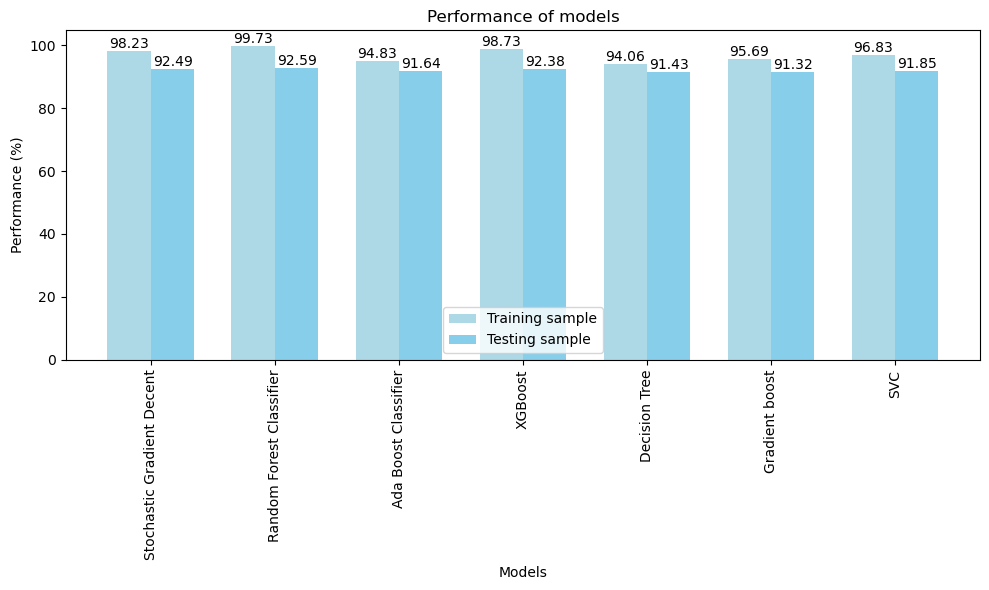

In [553]:
models = ['Stochastic Gradient Decent', 'Random Forest Classifier', 'Ada Boost Classifier', 'XGBoost', 
          'Decision Tree', 'Gradient boost', 'SVC']

X_train_mean_performance = [98.23, 99.73, 94.83, 98.73, 94.06, 95.69, 96.83]
X_test_mean_performance = [92.49, 92.59, 91.64, 92.38, 91.43, 91.32, 91.85]

bar_width = 0.35

plt.figure(figsize=(10, 6))

index = range(len(models))

plt.bar(index, X_train_mean_performance, bar_width, color = 'lightblue', label = 'Training sample')

plt.bar([i + bar_width for i in index], X_test_mean_performance, bar_width, color = 'skyblue', label = 'Testing sample')

plt.title('Performance of models')
plt.xlabel('Models')
plt.ylabel('Performance (%)')

plt.xticks([i + bar_width / 2 for i in index], models, rotation = 90)

plt.legend()

for i, value in enumerate(X_train_mean_performance):
    plt.text(i, value + 1, str(value), ha = 'center')

for i, value in enumerate(X_test_mean_performance):
    plt.text(i + bar_width, value + 1, str(value), ha = 'center')

plt.tight_layout()
plt.show()

### Conclusion:
    - we can conclude that removing numbers from reviews did not greatly affect the performance of the models

## Pipeline with target

In [547]:
X = df_main.drop(labels = ['feedback', 'target'], axis = 1)
X

,length,date_year,date_month,date_day,072318,1,10,100,1000,100x,...,variation_Black,variation_White,variation_Black Spot,variation_White Spot,variation_Black Show,variation_White Show,variation_Black Plus,variation_White Plus,variation_Configuration: Fire TV Stick,variation_Black Dot
0,13,2018,7,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,2018,7,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,195,2018,7,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,172,2018,7,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,2018,7,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,50,2018,7,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3146,135,2018,7,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3147,441,2018,7,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3148,380,2018,7,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [548]:
y = df_main['target']
y

0       1
1       1
2       0
3       1
4       1
       ..
3145    1
3146    1
3147    1
3148    1
3149    0
Name: target, Length: 3150, dtype: int64

In [549]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [550]:
algorithms = [
    ('Stochastic Gradient Decent', SGDClassifier()),
    ('Random Forest', RandomForestClassifier(n_estimators = 300)),
    ('Ada Boost', AdaBoostClassifier()),
    ('XGBoost', XGBClassifier()),
    ('Decision Tree', DecisionTreeClassifier(max_depth = 5)),
    ('Gradient boost', GradientBoostingClassifier()),
    ('SVC', SVC(kernel = 'poly')),
]

In [551]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    algorithms
])

for name, algorithm in algorithms:
    pipe.steps[-1] = (name, algorithm)
    
    pipe.fit(X_train, y_train)
    y_pred_test = pipe.predict(X_test)
    y_pred_train = pipe.predict(X_train)
    
    train_set = round(pipe.score(X_train, y_train) * 100, 2)
    test_set = round(pipe.score(X_test, y_test) * 100, 2)
    
    print(f"Train dataset with {name}: {train_set}%")
    print(f"Test dataset with {name}: {test_set}%")
    
    print(classification_report(y_train, y_pred_train))
    print(classification_report(y_test, y_pred_test))
    
    confusion_matrix(y_train, y_pred_train)
    confusion_matrix(y_test, y_pred_test)
    
    scores = cross_val_score(pipe, X_train, y_train, cv = 8, scoring='accuracy')

    print('Scores: ', scores, "\n")
    print('Mean: ', scores.mean(), '\n')
    print('Standard deviation: ', scores.std())

Train dataset with Stochastic Gradient Decent: 96.9%
Test dataset with Stochastic Gradient Decent: 80.63%
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       690
           1       0.97      0.99      0.98      1830

    accuracy                           0.97      2520
   macro avg       0.97      0.95      0.96      2520
weighted avg       0.97      0.97      0.97      2520

              precision    recall  f1-score   support

           0       0.75      0.44      0.56       174
           1       0.82      0.95      0.88       456

    accuracy                           0.81       630
   macro avg       0.79      0.69      0.72       630
weighted avg       0.80      0.81      0.79       630

Scores:  [0.80952381 0.81587302 0.80634921 0.8031746  0.7968254  0.82222222
 0.80952381 0.81269841] 

Mean:  0.8095238095238095 

Standard deviation:  0.007273929674533078
Train dataset with Random Forest: 99.33%
Test dataset with Random Fo

### Graphs to display performance

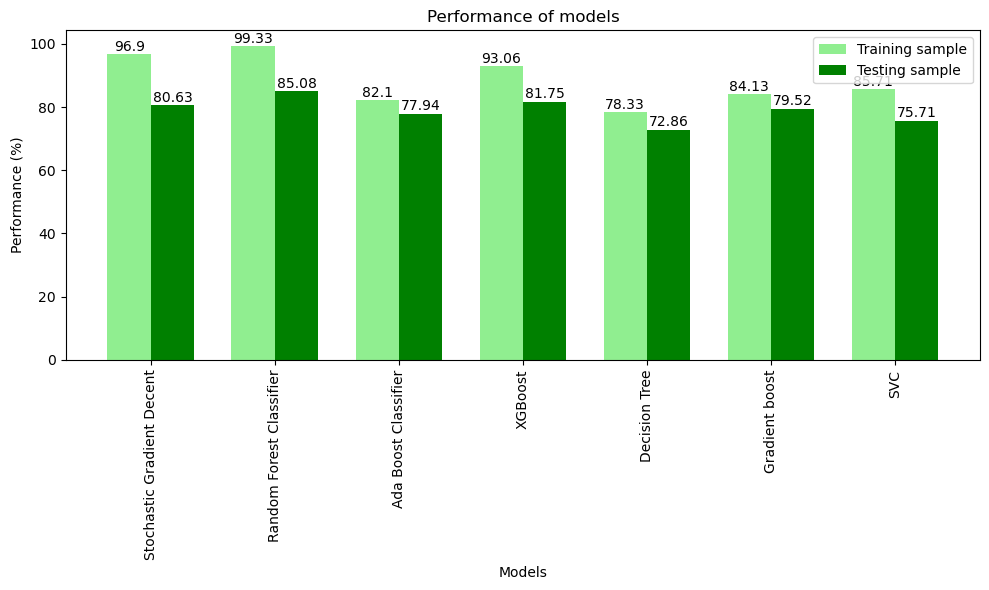

In [555]:
models = ['Stochastic Gradient Decent', 'Random Forest Classifier', 'Ada Boost Classifier', 'XGBoost', 
          'Decision Tree', 'Gradient boost', 'SVC']

X_train_mean_performance = [96.9, 99.33, 82.1, 93.06, 78.33, 84.13, 85.71]
X_test_mean_performance = [80.63, 85.08, 77.94, 81.75, 72.86, 79.52, 75.71]

bar_width = 0.35

plt.figure(figsize=(10, 6))

index = range(len(models))

plt.bar(index, X_train_mean_performance, bar_width, color = 'lightgreen', label = 'Training sample')

plt.bar([i + bar_width for i in index], X_test_mean_performance, bar_width, color = 'green', label = 'Testing sample')

plt.title('Performance of models')
plt.xlabel('Models')
plt.ylabel('Performance (%)')

plt.xticks([i + bar_width / 2 for i in index], models, rotation = 90)

plt.legend()

for i, value in enumerate(X_train_mean_performance):
    plt.text(i, value + 1, str(value), ha = 'center')

for i, value in enumerate(X_test_mean_performance):
    plt.text(i + bar_width, value + 1, str(value), ha = 'center')

plt.tight_layout()
plt.show()

### Conclusion:
    - It should be concluded that with an artificially created target variable to balance the dataset, the performance of the models drops

## Conclusion:
    - As we see after analyzing the data and training the models, the data set is unbalanced: there are more positive reviews than negative ones. The decision tree classifier model performed best. The other models performed slightly worse. The experiment of removing numbers from the “reviews” variable did not significantly affect the performance of the models. In our dataset, we tried to transform the date variable and remove unnecessary variables. This had a better effect on the performance of the models.